In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def read_datasets(folder):
    
    names = ['fluos', 'ods', 'fluos-lower-1', 'fluos-lower-2']
    datasets = []
    for name in names:
        datasets.append(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, name), index_col='time'))
    return datasets

In [3]:
promoters = ['pBAD/Ara', 'pCin/OHC14', 'pCymRC/Cuma', 'pLuxB/AHL', 'pPhlF/DAPG', 'pSalTTC/Sal', 'pRhaB/Rha']
ecfs = ['e11x33', 'e15x33', 'e16x33','e20x33', 'e32x33', 'e34x33', 'e38x33', 'e41x33', 'e42x33']
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB', 'e34x30MjaKlbA',
         'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']

#### Promoters Characterization - 6 induction levels

In [ ]:
folder = '004-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
fluos_ods = fluos_2 / ods

In [ ]:
aras = [0, 0.8125, 3.25, 13, 52, 208]
ohcs = [0, 0.039, 0.156, 0.625, 2.5, 10]
cumas = [0, 6.25, 12.5, 25, 50, 100]
ahls = [0, 0.039, 0.156, 0.625, 2.5, 10]
dapgs = [0, 0.098, 0.391, 1.563, 6.25, 25]
sals = [0, 0.391, 1.563, 6.25, 25, 100]
rhas = [0, 59.766, 239.063, 956.25, 3825, 15300]
inducers = [aras, ohcs, cumas, ahls, dapgs, sals, rhas]

In [ ]:
idx = 3 * 10
gfp = fluos_2[filter(lambda x: x.startswith('positive-control-amp'), fluos_ods.columns)].mean(axis=1)
neg = fluos_2[filter(lambda x: x.startswith('negative-control-kan'), fluos_ods.columns)].mean(axis=1)
gfp10, neg10 = gfp.iloc[idx], neg.iloc[idx]
gfp10, neg10

In [ ]:
f, axs = plt.subplots(7, 2, sharex=True, sharey=False, figsize=(6, 10))
for i in range(7):
    for j in range(3):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--')
        axs[i, 0].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(3, 6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--')
        axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
def promoters_plots(row, col, data, promoters, sharex=True, sharey=False):
    
    #xs = np.arange(12)
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(6):
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - neg.iloc[idx]) / (gfp.iloc[idx] - neg.iloc[idx])
                ax.scatter(np.log(inducers[i][j]), np.log(rpu))
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    
    return responses

responses = promoters_plots(2, 4, fluos_2, promoters, sharex=False, sharey=False)

#### Promoters Characterization - 12 induction levels

In [49]:
def get_control(fluos, h):

    idx = 3 * h
    gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
    neg_amp = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
    neg_kan = fluos[filter(lambda x: x.startswith('negative-control-kan'), fluos.columns)].mean(axis=1)
    neg_kan_10, gfp_10, neg_amp_10 = neg_kan.iloc[idx], gfp.iloc[idx], neg_amp.iloc[idx]
    return neg_kan_10, gfp_10, neg_amp_10

def promoters_plots(row, col, data, promoters, ctrl, h, sharex=True, sharey=False):
    
    idx = 3 * h
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(12):
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - ctrl[0]) / (ctrl[1] - ctrl[2])
                ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 2))
                ax.loglog()
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            #ax.legend(bbox_to_anchor=(1.1, 1.1))
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    return responses

In [50]:
#006
folder = '006-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
selected = ['pBAD/Ara', 'pCin/OHC14', 'pCymRC/Cuma', 'pPhlF/DAPG', 'pSalTTC/Sal', 'pRhaB/Rha', 'positive-control', 'negative-control']
selected_fluos = pd.concat([fluos_2[filter(lambda x: x.startswith(i), fluos.columns)] for i in selected], axis=1)

#fluos_ods = fluos_2 / ods
aras = [0, 0.40625, 0.8125, 1.625, 3.25, 6.5, 13, 26, 52, 104, 208, 416]
ohcs = [0, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5, 10, 20, 40, 80, 160]
cumas = [0, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800]
ahls = [0, 0.01953125, 0.0390625, 0.078125, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5, 10, 20]
dapgs = [0, 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50]
sals = [0, 1.5625, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600]
rhas = [0, 14.94140625, 29.8828125, 59.765625, 119.53125, 239.0625, 478.125, 956.25, 1912.5, 3825, 7650, 15300]
inducers = [aras, ohcs, cumas, ahls, dapgs, sals, rhas]

<ipython-input-49-b3253b9dac7b>:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog()
<ipython-input-49-b3253b9dac7b>:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 2))


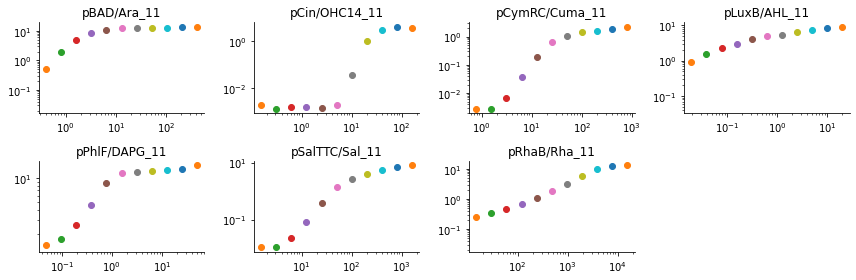

In [51]:
responses = promoters_plots(2, 4, fluos_2, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [52]:
df_res1 = pd.DataFrame(responses).T
df_res1.columns = promoters
df_ind1 = pd.DataFrame(inducers).T
df_ind1.columns = promoters

<ipython-input-49-b3253b9dac7b>:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog()
<ipython-input-49-b3253b9dac7b>:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 2))


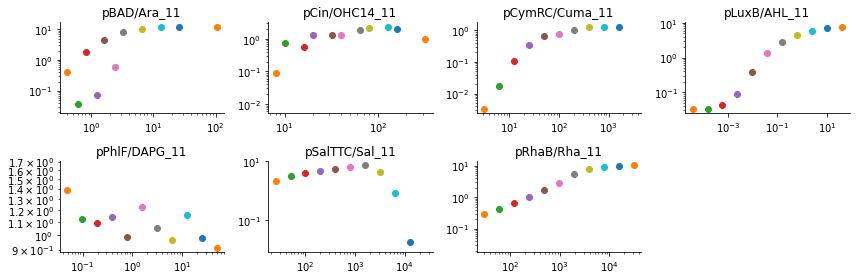

In [53]:
#010 - AHL & Rha
folder = '010-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras = [0, 0.406, 0.609, 0.813, 1.219, 1.625, 2.438, 3.25, 6.5, 13, 26, 104]
ohcs = [0, 8, 10, 16, 20, 32, 40, 64, 80, 128, 160, 320]
cumas = [0, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600, 3200]
ahls = [0, 3.81e-5, 1.53e-4, 6.1e-4, 2.44e-3, 9.77e-3, 3.91e-2, 0.156, 0.625, 2.5, 10, 40]
dapgs = [0, 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50] #does not matter
sals = [0, 25, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
rhas = [0, 29.88, 59.76, 119.53, 239.06, 478.125, 956.25, 1912.5, 3825, 7650, 15300, 30600]
inducers = [aras, ohcs, cumas, ahls, dapgs, sals, rhas]
responses = promoters_plots(2, 4, fluos_2, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [54]:
df_res2 = pd.DataFrame(responses).T
df_res2.columns = promoters
df_ind2 = pd.DataFrame(inducers).T
df_ind2.columns = promoters

In [116]:
df_res = pd.concat([df_res1.drop(['pLuxB/AHL'], axis=1), df_res2[['pLuxB/AHL']]], axis=1)
df_ind = pd.concat([df_ind1.drop(['pLuxB/AHL'], axis=1), df_ind2[['pLuxB/AHL']]], axis=1)

<ipython-input-119-caec7a488776>:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog()
<ipython-input-119-caec7a488776>:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x, y)


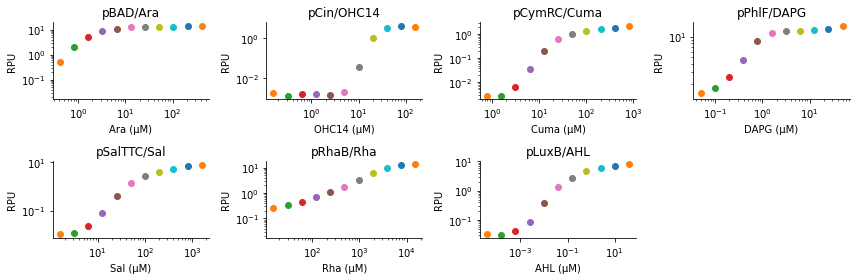

In [119]:
def promoters_combined_plots(row, col, data, inducers):
    
    ind_names = ['Ara', 'OHC14', 'Cuma', 'DAPG', 'Sal', 'Rha', 'AHL']
    cols = data.columns.tolist()
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            for x, y in zip(inducers[cols[i]], data[cols[i]]):
                ax.scatter(x, y)
                ax.loglog()
            ax.set_title('{}'.format(cols[i]))
            ax.set_ylabel('RPU')
            ax.set_xlabel('{} ({})'.format(ind_names[i], u"\u03bcM"))
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
                         
promoters_combined_plots(2, 4, df_res, df_ind)

pBAD/Ara [2.66541774e+00 1.25497718e+00 1.22810793e-02 1.39733471e+01]
pCin/OHC14 [ 2.85680307e+01  3.30858313e+00 -8.70882187e-03  4.17973680e+00]
pCymRC/Cuma [ 6.73763801e+01  1.07985561e+00 -7.31832478e-03  2.25303592e+00]
pLuxB/AHL [ 0.817593    1.22709251  1.32597087 14.39638967]
pPhlF/DAPG [1.00000000e+02 1.11722481e+00 1.63880152e-04 8.10842410e+00]
pSalTTC/Sal [0.4213906  0.67814923 0.02225343 7.83527956]
pRhaB/Rha [1.00000000e+02 2.66904635e-01 1.44919079e-02 1.04212531e+01]


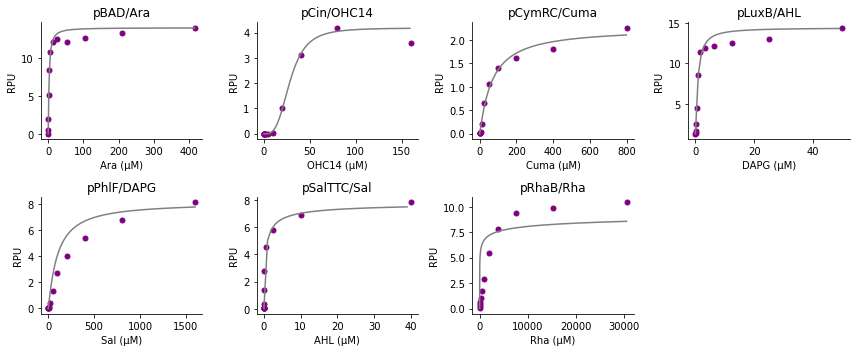

In [113]:
ind_names = ['Ara', 'OHC14', 'Cuma', 'DAPG', 'Sal', 'AHL', 'Rha']
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        y = np.array(df_res.iloc[:, i])
        x = np.array(df_ind.iloc[:, i])
        init_guess = [10, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, y.min()-0.01, y.max()-0.01],
                       [100, 5, y.min()+0.01, y.max()+0.01]]
        
        popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)
        print(promoters[i], popt)
        ax.scatter(x, y, color='purple', s=25)
        ax.plot(np.arange(x[-1]), hill_activation(np.arange(x[-1]), *popt), color='gray')
        #ax.loglog()
        
        ax.set_title('{}'.format(promoters[i]))
        #ax.set_xticks(np.arange(12))
        #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(ind_names[i], u"\u03bcM"))
        #ax.legend()
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

In [118]:
df_res.to_csv('datasets/experiment/responses.csv', index=False)
df_ind.to_csv('datasets/experiment/inducers.csv', index=False)

Data Inspections

In [ ]:
f, axs = plt.subplots(7, 2, sharex=True, sharey=False, figsize=(6, 10))
for i in range(7):
    for j in range(6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--', label='10h')
        #axs[i, 1].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('Fluo (a.u.)')
        axs[i, 0].set_xlabel('Hour')
    for j in range(6, 12):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--', label='10h')
        #axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('Fluo (a.u.)')
        axs[i, 1].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(7, 12, sharex=True, sharey=True, figsize=(20, 10))
for i in range(7):
    for j in range(12):
        r0 = fluos_2['{}_{}'.format(promoters[i], j)]
        axs[i, j].plot(r0.index/60, r0, color='darkblue')
        axs[i, j].axvline(10, color='red', linestyle='--', label='10h')
        axs[i, j].legend()
        axs[i, j].set_title('{}_{}'.format(promoters[i], j))
        axs[i, j].set_ylabel('Fluo (a.u.)')
        axs[i, j].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

#### ECFs characterization

In [ ]:
def ecf_plots(row, col, data, gates, ecfs, sharex=True, sharey=False, od=False):

    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    for i in range(row):
        for j in range(col):
            gate = gates[i]
            ecf = ecfs[i]
            d1 = data['{}_{}'.format(ecf, j)]
            d2 = data['{}_{}'.format(gate, j)]
            axs[i, j].plot(d1.index/60, d1, label='intact ECF')
            axs[i, j].plot(d2.index/60, d2, label='split ECF')
            axs[i, j].set_title('{}_{}'.format(gate, j))
            axs[i, j].legend()
            axs[i, j].set_ylabel('OD' if od else 'Fluo (a.u)')
            axs[i, j].set_xlabel('Hour')
        sns.despine()
    plt.tight_layout()

def compare_ecf_plots(row, col, datas, gates, ecfs, sharex=True, sharey=False, od=False):

    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    for i in range(row):
        for j in range(col):
            gate = gates[i]
            ecf = ecfs[i]
            d1 = datas[0]['{}_{}'.format(ecf, j)]
            d2 = datas[1]['{}_{}'.format(ecf, j)]
            d3 = datas[0]['{}_{}'.format(gate, j)]
            d4 = datas[1]['{}_{}'.format(gate, j)]
            axs[i, j].plot(d1.index/60, d1, label='intact ECF - 1')
            axs[i, j].plot(d2.index/60, d2, label='intact ECF - 2')
            axs[i, j].plot(d3.index/60, d3, label='split ECF - 1')
            axs[i, j].plot(d4.index/60, d4, label='split ECF - 2')
            axs[i, j].set_title('{}_{}'.format(gate, j))
            #axs[i, j].legend()
            axs[i, j].set_ylabel('OD' if od else 'Fluo (a.u)')
            axs[i, j].set_xlabel('Hour')
            #axs[i, j].set_ylim([0, 1.5])
        sns.despine()
    plt.tight_layout()

In [ ]:
folder = '005-intact-vs-gate-ecfs'
fluos_005, ods_005, fluos_1_005, fluos_2_005 = read_datasets(folder)
folder = '007-intact-vs-gate-ecfs'
fluos_007, ods_007, fluos_1_007, fluos_2_007 = read_datasets(folder)

In [ ]:
#005 & 007
aras = [0, 0.81, 3.25, 13, 52, 208]
cumas = [0, 6.25, 12.5, 25, 50, 100]
#009
#aras = [0, 26, 52, 104, 208, 416]
#cumas = [0, 50, 100, 200, 400, 800]
ecfs = ['e20x33', 'e32x33', 'e34x33', 'e38x33', 'e41x33', 'e42x33']
gates = ['e20x32gp411', 'e32x30SspGyrB', 'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']

In [ ]:
compare_ecf_plots(6, 6, [(fluos_2_005), (fluos_2_007)], gates, ecfs)

In [ ]:
compare_ecf_plots(6, 6, [ods_005, ods_007], gates, ecfs)

In [ ]:
ecf_plots(6, 6, fluos_2, gates, ecfs)

In [ ]:
ecf_plots(6, 6, ods, gates, ecfs, od=True)

In [ ]:
ecf_plots(6, 6, fluos_2, gates, ecfs)

In [ ]:
ecf_plots(6, 6, ods, gates, ecfs, od=True)

#### Initial Experiments

In [ ]:
f_fluos = pd.read_csv('datasets/induction_matrix_and/fluos.csv', index_col='time')
f_ods = pd.read_csv('datasets/induction_matrix_and/ods.csv', index_col='time')
r0_fluos = pd.read_csv('datasets/experiment/plate-1/plate1-fluos.csv', index_col='time')
r0_ods = pd.read_csv('datasets/experiment/plate-1/plate1-ods.csv', index_col='time')
r1_fluos = pd.read_csv('datasets/experiment/plate-2/plate2-fluos.csv', index_col='time')
r1_ods = pd.read_csv('datasets/experiment/plate-2/plate2-ods.csv', index_col='time')
r2_fluos = pd.read_csv('datasets/experiment/plate-3/plate3-fluos.csv', index_col='time')
r2_ods = pd.read_csv('datasets/experiment/plate-3/plate3-ods.csv', index_col='time')

r0l_fluos = pd.read_csv('datasets/experiment/plate-1/plate1-fluos-gain-lower-1.csv', index_col='time')
r0ll_fluos = pd.read_csv('datasets/experiment/plate-1/plate1-fluos-gain-lower-2.csv', index_col='time')
r1l_fluos = pd.read_csv('datasets/experiment/plate-2/plate2-fluos-gain-lower-1.csv', index_col='time')
r1ll_fluos = pd.read_csv('datasets/experiment/plate-2/plate2-fluos-gain-lower-2.csv', index_col='time')
r2l_fluos = pd.read_csv('datasets/experiment/plate-3/plate3-fluos-gain-lower-1.csv', index_col='time')
r2ll_fluos = pd.read_csv('datasets/experiment/plate-3/plate3-fluos-gain-lower-2.csv', index_col='time')

### EDA

In [ ]:
xs = np.arange(6)
aras = [0, 0, 3.25, 13, 52, 208, 832]
ohcs = [0, 0, 0.04, 0.16, 0.63, 2.5, 10]
cumas = [0, 0, 6.25, 12.5, 25, 50, 100]
ahls = [0, 0, 0.04, 0.16, 0.63, 2.5, 10]
dapgs = [0, 0, 0.1, 0.39, 1.56, 6.25, 25]
sals = [0, 0, 0.39, 1.56, 6.25, 25, 100]
rhas = [0, 0, 59.76, 239, 956, 3825, 15300]
inducers = [aras, ohcs, cumas, ahls, dapgs, sals, rhas]

In [ ]:
idx = 30
gfp = r0ll_fluos[filter(lambda x: x.startswith('positive-control'), r0ll_fluos.columns)].mean(axis=1)
af = r0ll_fluos[filter(lambda x: x.startswith('negative-control-amp'), r0ll_fluos.columns)].mean(axis=1)

gfp10, af10 = gfp.iloc[idx], af.iloc[idx]
gfp10, af10

In [ ]:
idx = 30
responses = []
f, axs = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(16, 6))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        response = []
        for j in range(6):
            r = r0ll_fluos['{}_{}'.format(promoters[i], j)]
            rpu = (r.iloc[idx] - af.iloc[idx]) / (gfp.iloc[idx] - af.iloc[idx])
            ax.scatter(xs[j], rpu, color='blue')
            
            r = r1ll_fluos['{}_{}'.format(promoters[i], j)]
            rpu = (r.iloc[idx] - af.iloc[idx]) / (gfp.iloc[idx] - af.iloc[idx])
            ax.scatter(xs[j], rpu, color='red')
            
            response.append(rpu)
            #responses.append(pd.Series(r.iloc[30], index=xs[j]))
        ax.set_title('{}_{}'.format(promoters[i], j))
        ax.set_xticklabels(inducers[i])
        responses.append(response)
    else:
        ax.set_visible(False)
sns.despine()
plt.tight_layout()

In [ ]:
ind_names = ['Ara', 'OHC14', 'Cuma', 'AHL', 'DAPG', 'Sal', 'Rha']
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        y = np.array(responses[i])
        init_guess = [10, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, y.min()-0.1, y.max()-0.1],
                       [100, 4, y.min()+0.1, y.max()+0.1]]
        popt, pcov = curve_fit(hill_activation, np.arange(6), y, p0=init_guess, bounds=gate_bounds)
        ax.scatter(np.arange(6), y, color='purple', s=25)
        ax.plot(np.arange(0, 6, 0.1), hill_activation(np.arange(0, 6, 0.1), *popt), color='gray')
        #ax.axhline(1, linestyle='dotted', label='J101_4A3')
        ax.set_title('{}'.format(promoters[i]))
        ax.set_xticks(np.arange(6))
        ax.set_xticklabels(inducers[i][1:])
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(ind_names[i], u"\u03bcM"))
        #ax.legend()
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

In [ ]:
responses[0], responses[2]

In [ ]:
idx = 30
fgfp = f_fluos[filter(lambda x: x.startswith('positive_control_4AE'), f_fluos.columns)].mean(axis=1)
faf = f_fluos[filter(lambda x: x.startswith('negative_control_4AE'), f_fluos.columns)].mean(axis=1)
fgfp.iloc[idx], faf.iloc[idx]

In [ ]:
f_fluos2 = f_fluos[filter(lambda x: x.startswith('e11x32STPhoRadA'), f_fluos.columns)]
fluo = (f_fluos2.iloc[idx] - faf.iloc[idx]) / (fgfp.iloc[idx] - faf.iloc[idx])
fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
#fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', t)
fluo_t

In [ ]:
f_fluos2

In [ ]:
cumas_rpu = [np.round(x, 2) for x in responses[3]]
aras_rpu = [np.round(x, 2) for x in responses[6]]

In [ ]:
cumas_rpu, aras_rpu

In [ ]:
def plot_heatmap(fluos, gates, num_row, num_col, t=600):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(16, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            fluo = f_fluos[filter(lambda x: x.startswith(gate), f_fluos.columns)]
            fluo = (fluo.iloc[idx] - faf.iloc[idx]) / (fgfp.iloc[idx] - faf.iloc[idx])
            fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
            fluo_t['cuma'] = fluo_t['gate'].str[-2]
            fluo_t['ara'] = fluo_t['gate'].str[-1]
            fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', t)
            fluo_pvt.index = cumas_rpu
            fluo_pvt.columns = aras_rpu
            sns.heatmap(fluo_pvt, annot=True, fmt='.2f', ax=ax, cmap='cividis')
            ax.set_xlabel('Ara [RPU]')
            ax.set_ylabel('Cuma [RPU]')
            ax.set_title(gate)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
plot_heatmap(fluo, gates, 3, 3)

In [ ]:
f, axs = plt.subplots(7, 6, sharex=True, sharey=False, figsize=(14, 10))
for i in range(7):
    for j in range(6):
        r0 = r0_ods['{}_{}'.format(promoters[i], j)]
        #axs[i, j].axvline(r0[r0==r0.max()].index[0]/60, color='gray')
        #r1 = r1_ods['{}_{}'.format(promoters[i], j)]
        #axs[i, j].axvline(r1[r1==r1.max()].index[0]/60, color='black')
        axs[i, j].plot(r0.index/60, r0, color='darkblue')
        #axs[i, j].plot(r1.index/60, r1, label='plate2')
        axs[i, j].axvline(10, color='red', linestyle='--', label='10h')
        axs[i, j].legend()
        axs[i, j].set_title('{}_{}'.format(promoters[i], j))
        axs[i, j].set_ylabel('Fluo (a.u.)')
        axs[i, j].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(7, 6, sharex=True, sharey=True, figsize=(14, 10))
for i in range(7):
    for j in range(6):
        r0 = r0ll_fluos['{}_{}'.format(promoters[i], j)]
        #axs[i, j].axvline(r0[r0==r0.max()].index[0]/60, color='gray')
        #r1 = r1_ods['{}_{}'.format(promoters[i], j)]
        #axs[i, j].axvline(r1[r1==r1.max()].index[0]/60, color='black')
        axs[i, j].plot(r0.index/60, r0, color='darkgreen')
        #axs[i, j].plot(r1.index/60, r1, label='plate2')
        axs[i, j].axvline(10, color='red', linestyle='--', label='10h')
        axs[i, j].legend()
        axs[i, j].set_title('{}_{}'.format(promoters[i], j))
        axs[i, j].set_ylabel('Fluo (a.u.)')
        axs[i, j].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
r0ll_fluos.index[30]/60

In [ ]:
f, axs = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(14, 10))
for i in range(6):
    for j in range(6):
        r0 = r0ll_fluos['{}_{}'.format(promoters[i], j)]
        r1 = r1ll_fluos['{}_{}'.format(promoters[i], j)]
        axs[i, j].plot(r0.index/60, r0, label='plate1')
        axs[i, j].plot(r1.index/60, r1, label='plate2')
        axs[i, j].legend()
        axs[i, j].set_title('{}_{}'.format(promoters[i], j))
sns.despine()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(6, 6, sharex=True, sharey=False, figsize=(12, 8))
gate = gates[1]
print(gate)
for i in range(6):
    for j in range(6):
        fg = f_ods['{}_{}{}'.format(gate, i, j)]
        fg_ = remove_outliers(fg)
        axs[i, j].plot(fg.index/60, fg)
        axs[i, j].plot(fg_.index/60, fg_)
        axs[i, j].set_title('{}_{}{}'.format(gate, i, j))
    sns.despine()
plt.tight_layout()

In [ ]:
def remove_outliers(ts):
    
    from sklearn.cluster import DBSCAN
    cl = DBSCAN(eps=0.1, min_samples=7).fit(np.array(ts).reshape(-1,1))
    labels = cl.labels_
    #outlier_pos = np.where(labels==-1)[0]
    thres = np.where(ts==ts.median())[0][0]
    #print(thres)
    removed = pd.Series([a if b==0 else np.NaN for a, b in zip(ts.tolist(), labels)])
    #removed = removed.fillna(removed.rolling(20, min_periods=1,).mean()).tolist()
    #removed = removed.interpolate(method='slinear').tolist()
    #print(thres, ts.iloc[thres], ts.median(), np.array(removed), np.array(ts.iloc[:thres].tolist() + removed[thres:]))
    print(thres, removed)
    return pd.Series(ts.iloc[:thres].tolist() + removed[thres:], index=ts.index)

### Time-series outliers removal

In [ ]:
new_ts = remove_outliers(r2_fluos['e20x32gp411_3'])
r2_fluos['e20x32gp411_3'].plot()
#new_ts.plot()

### Gates

In [ ]:
r1l_gfp = r1l_fluos[filter(lambda x: x.startswith('positive-control-amp'), r1l_fluos.columns)].mean(axis=1)
r1l_neg = r1l_fluos[filter(lambda x: x.startswith('negative-control-amp'), r1l_fluos.columns)].mean(axis=1)
r1l_fluos_rpu = np.abs(r1l_fluos - neg.iloc[idx]) / np.abs(gfp.iloc[idx] - neg.iloc[idx])

In [ ]:
data = pd.concat([r0l_fluos, r2l_fluos], axis=1)
data

In [ ]:
f, axs = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(16, 8))
for i in range(5, 9):
    for j in range(5):
        gate = gates[i]
        ecf = ecfs[i]
        e = data['{}_{}'.format(ecf, j)]
        g = data['{}_{}'.format(gate, j)]
        axs[i-5, j].plot(e.index[:45]/60, e[:45], label='intact ECF')
        axs[i-5, j].plot(g.index[:45]/60, g[:45], label='split ECF')
        axs[i-5, j].set_title('{}_{}'.format(gate[:6], j))
        axs[i-5, j].legend()
        axs[i-5, j].set_ylabel('Fluo (a.u)')
        axs[i-5, j].set_xlabel('Hour')
    sns.despine()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(16, 10))
for i, gate in enumerate(gates[3:]):
    for j in range(5):
        fg = f_fluos['{}_{}{}'.format(gate, j, j)]
        r2g = r2_fluos['{}_{}'.format(gate, j)]
        #axs[i, j-1].plot(fg.index/60, fg, label='Filipe')
        axs[i, j].plot(r2g.index/60, r2g, label='Plate-3')
        axs[i, j].set_title('{}_{}'.format(gate, j))
        axs[i, j].legend()
    sns.despine()
plt.tight_layout()

In [ ]:
plt.figure(figsize=[10, 3])
plt.subplot(121)
f_neg = f_ods[filter(lambda x: x.startswith('negative_control'), f_ods.columns)]
plt.plot(f_neg.index/60, f_neg)
plt.title('Filipe - negative control')
sns.despine()
plt.subplot(122)
f_pos = f_ods[filter(lambda x: x.startswith('positive_control_4AE'), f_ods.columns)]
plt.plot(f_pos.index/60, f_pos)
plt.title('Filipe - positive control')
sns.despine()

In [ ]:
plt.figure(figsize=[12, 3])
plt.subplot(141)
r0_neg = r0_ods[filter(lambda x: x.startswith('negative-control'), r0_ods.columns)]
plt.plot((r0_neg.index+160)/60, r0_neg)
plt.title('Plate 1 - negative control')
sns.despine()
plt.subplot(142)
r0_pos = r0_ods[filter(lambda x: x.startswith('positive-control'), r0_ods.columns)]
plt.plot((r0_pos.index+160)/60, r0_pos)
plt.title('Plate 1 - positive control')
sns.despine()
plt.subplot(143)
r1_neg = r1_ods[filter(lambda x: x.startswith('negative-control'), r1_ods.columns)]
plt.plot(r1_neg.index/60, r1_neg)
plt.title('Plate 2 - negative control')
sns.despine()
plt.subplot(144)
r1_pos = r1_ods[filter(lambda x: x.startswith('positive-control'), r1_ods.columns)]
plt.plot(r1_pos.index/60, r1_pos)
plt.title('Plate 2 - positive control')
sns.despine()

In [ ]:
plt.figure(figsize=[10, 3])
plt.subplot(121)
f_neg = f_fluos[filter(lambda x: x.startswith('negative_control_4AE'), f_fluos.columns)]
plt.plot(f_neg.index/60, f_neg)
plt.title('Filipe - negative control')
#plt.ylim([0, 80000])
sns.despine()
plt.subplot(122)
f_pos = f_fluos[filter(lambda x: x.startswith('positive_control_4AE'), f_fluos.columns)]
plt.plot(f_pos.index/60, f_pos)
plt.title('Filipe - positive control')
#plt.ylim([0, 80000])
sns.despine()

In [ ]:
plt.figure(figsize=[16, 2.5])
plt.subplot(141)
r0_neg = r0_fluos[filter(lambda x: x.startswith('negative-control-amp'), r0_fluos.columns)]
plt.plot((r0_neg.index+160)/60, r0_neg)
plt.title('Plate 1 - negative control')
#plt.ylim([0, 80000])
sns.despine()
plt.subplot(142)
r0_pos = r0_fluos[filter(lambda x: x.startswith('positive-control'), r0_fluos.columns)]
plt.plot((r0_pos.index+160)/60, r0_pos)
plt.title('Plate 1 - positive control')
#plt.ylim([0, 80000])
sns.despine()
plt.subplot(143)
r1_neg = r1_fluos[filter(lambda x: x.startswith('negative-control-amp'), r1_fluos.columns)]
plt.plot(r1_neg.index/60, r1_neg)
plt.title('Plate 2 - negative control')
#plt.ylim([0, 80000])
sns.despine()
plt.subplot(144)
r1_pos = r1_fluos[filter(lambda x: x.startswith('positive-control'), r1_fluos.columns)]
plt.plot(r1_pos.index/60, r1_pos)
plt.title('Plate 2 - positive control')
#plt.ylim([0, 80000])
sns.despine()

### ECFs Control

In [ ]:
f, axs = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(16, 6))
for i, gate in enumerate(ecfs[:3]):
    for j in range(5):
        #fg = f_fluos['{}_{}{}'.format(gate, j, j)]
        r0g = r3_fluos['{}_{}'.format(gate, j)]
        r1g = r4_fluos['{}_{}'.format(gate, j)]
        #axs[i, j].plot(fg.index/60, fg, label='Filipe')
        axs[i, j].plot(r0g.index/60, r0g, label='Plate-1')
        axs[i, j].plot(r1g.index/60, r1g, label='Plate-2')
        axs[i, j].set_title('{}_{}'.format(gate, j))
        axs[i, j].legend()
    sns.despine()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(16, 10))
for i, gate in enumerate(ecfs[:3]):
    for j in range(5):
        r2g = r4_fluos['{}_{}'.format(gate, j)]
        axs[i, j].plot(r2g.index/60, r2g, label='Plate-3')
        axs[i, j].set_title('{}_{}'.format(gate, j))
        axs[i, j].legend()
    sns.despine()
plt.tight_layout()

In [ ]:
r2_fluos.columns

In [ ]:
ts = r2_fluos['e42x32STIMPDH1_4']
ts.plot()
plt.axhline(ts.std()*2.5)
plt.axhline(ts.median(), color='r')

In [ ]:
r0_ods['negative-control-amp_1.1'].plot()

In [ ]:
from sklearn.cluster import DBSCAN
ts = r0_ods['negative-control-amp_1.1']
clustering1 = DBSCAN(eps=0.1, min_samples=6).fit(np.array(ts).reshape(-1,1))
labels = clustering1.labels_
outlier_pos = np.where(labels==-1)[0]

x, y = [], []
for pos in outlier_pos:
    x.append(ts.index[pos])
    y.append(np.array(ts)[pos])
    
plt.plot(ts, '-')
plt.plot(x, y, 'r*', markersize=8)  
plt.legend(['Actual', 'Anomaly Detected'])
plt.show()

In [ ]:
thres = np.where(ts==ts.median())[0][0]
removed = pd.Series([a if b==0 else np.NaN for a, b in zip(ts.tolist(), labels)])
removed = removed.fillna(removed.rolling(3, min_periods=1,).mean()).tolist()
new_ts = pd.Series(ts.iloc[:thres].tolist() + removed[thres:]).plot()

In [ ]:
ta = r2_fluos['e20x33_0']
sns.kdeplot(ta)
plt.axvline(ta.mean(), c='b')
plt.axvline(ta.median(), c='r')

In [ ]:
ts.iloc[np.where(ts==ts.median())[0][0]:].plot()

In [ ]:
ts.iloc[39], ts.median()

In [ ]:
labels[np.where(ts==ts.median())[0][0]:]

In [ ]:
np.where(labels[np.where(ts==ts.median())[0][0]:]==-1)